<a href="https://colab.research.google.com/github/rwlopez98/OpenPose-Colab-Notebook/blob/main/Rebuilt_OpenPose_w_Matlab_Exports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pose Detection with OpenPose

This notebook uses an open source project [CMU-Perceptual-Computing-Lab/openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose.git) to detect/track multi person poses on a given video.

Please read the [OpenPose license](https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/LICENSE) before running this script. (LOL Cause we really gonna do all that)

## **READ THIS BEFORE EXECUTING**
1. Scroll through and READ all section headers below before running the first time to understand the warnings and issues that may/will happen. This program WILL mount to your Google Drive and may cause undesired effects.
2. Make sure that you have GPU hardware enabled in the top right under your resources. This setup is configured to leverage GPU acceleration and will not work without it.
3. The first time you execute this project you will just "Run All". After that you just have to execute the "Define Sample Video" sections on down as needed to accomplish what you're attempting to do.


#Pre-configuration

**WARNING: IF YOU EXECUTE THIS SECTION BLOCK AND PERMIT ACCESS, A NEW FOLDER BY THE NAME OF "dataOutput" WILL BE CREATED. THIS WILL OVERWRITE EXISTING FOLDERS BY THE SAME NAME IN THE ROOT DIRECTORY OF THE MOUNTED GOOGLE DRIVE ACCOUNT.**

Note:
1. If you wish to change the folder name/location edit that below where indicated before executing this code block

In [ ]:
#Mounting to our Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#The following where we define the new directory in the mounted Google Drive account.
!mkdir -p '/content/drive/My Drive/dataOutput'

In [ ]:
#Importing our OS and defining our HOME_PATH for later use.
import os
OPENPOSE_PATH="./openpose/"
HOME_PATH='./'

In [ ]:
!echo $HOME_PATH

./


#Download Openpose Files

In [ ]:
#@title
!pip install ffmpeg-python
from os.path import exists, join, basename, splitext

def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))


# see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
# install new CMake becaue of CUDA10
!wget -q https://cmake.org/files/v3.17/cmake-3.17.2-Linux-x86_64.tar.gz
!tar xfz cmake-3.17.2-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local

# install system dependencies
!apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
!rm -rf openpose
# clone openpose
!git clone -q --depth 1 $git_repo_url
# --recursive necessary in the line below, as otherwise you can (sometimes) get "lpthreads" errors in cmake ("undefined reference to `pthread_create'" etc). See, for example, https://github.com/facebookarchive/caffe2/issues/1234
!sed -i 's/execute_process(COMMAND git checkout --recursive master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
!cd openpose && git submodule update --init --recursive --remote

Selecting previously unselected package liblmdb0:amd64.
(Reading database ... 123632 files and directories currently installed.)
Preparing to unpack .../00-liblmdb0_0.9.24-1build2_amd64.deb ...
Unpacking liblmdb0:amd64 (0.9.24-1build2) ...
Selecting previously unselected package libgflags2.2.
Preparing to unpack .../01-libgflags2.2_2.2.2-2_amd64.deb ...
Unpacking libgflags2.2 (2.2.2-2) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../02-libgflags-dev_2.2.2-2_amd64.deb ...
Unpacking libgflags-dev (2.2.2-2) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../03-libgoogle-glog0v5_0.5.0+really0.4.0-2_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.5.0+really0.4.0-2) ...
Selecting previously unselected package libunwind-dev:amd64.
Preparing to unpack .../04-libunwind-dev_1.3.2-2build2.1_amd64.deb ...
Unpacking libunwind-dev:amd64 (1.3.2-2build2.1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to un

#File Download Hash Mismatch Fix

Workaround for server problem `file DOWNLOAD HASH mismatch` when building OpenPose.

Due to the size of the model folder, you might have to wait a bit for it to actually execute and pull the entirety of the dependant models.

In [ ]:
#Downloading the models from a private drive location since the original servers are down.
!gdown --id 1_z6tj09sfHw833tJfzmpRuLSxdzWMQ8Y -O models.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1_z6tj09sfHw833tJfzmpRuLSxdzWMQ8Y
From (redirected): https://drive.google.com/uc?id=1_z6tj09sfHw833tJfzmpRuLSxdzWMQ8Y&confirm=t&uuid=1eabfc38-42c8-40d1-85e9-ede9ffced006
To: /content/models.zip
100% 2.58G/2.58G [00:38<00:00, 67.7MB/s]


In [ ]:
#Unpacking the models.zip
!unzip -o models.zip -d openpose

cmake-3.17.2-Linux-x86_64.tar.gz  drive  models.zip  openpose  sample_data
Archive:  models.zip
 extracting: openpose/models/pose/coco/pose_iter_440000.caffemodel  
 extracting: openpose/models/pose/coco/main.html  
 extracting: openpose/models/pose/mpi/pose_iter_160000.caffemodel  
 extracting: openpose/models/pose/body_25/pose_iter_584000.caffemodel  
 extracting: openpose/models/pose/body_25/training_results_source.txt  
 extracting: openpose/models/pose/body_25/training_log.txt  
   creating: openpose/models/pose/body_21a_video/
 extracting: openpose/models/pose/body_21a_video/pose_deploy.prototxt  
 extracting: openpose/models/pose/body_21a_video/pose_iter_264000.caffemodel  
   creating: openpose/models/pose/1_25BSuperModel11FullVGG/
   creating: openpose/models/pose/1_25BSuperModel11FullVGG/body_25b/
 extracting: openpose/models/pose/1_25BSuperModel11FullVGG/body_25b/training_log.txt  
 extracting: openpose/models/pose/1_25BSuperModel11FullVGG/body_25b/pose_iter_636000.caffemode

In [ ]:
# use 'sed' to comment out the line in the OpenPose repo that downloads the model from the failed link
! sed -i 's/executeShInItsFolder "getModels.sh"/# executeShInItsFolder "getModels.sh"/g' ./openpose/scripts/ubuntu/install_openpose_JetsonTX2_JetPack3.1.sh
! sed -i 's/executeShInItsFolder "getModels.sh"/# executeShInItsFolder "getModels.sh"/g' ./openpose/scripts/ubuntu/install_openpose_JetsonTX2_JetPack3.3.sh
! sed -i 's/download_model("BODY_25"/# download_model("BODY_25"/g' ./openpose/CMakeLists.txt
! sed -i 's/78287B57CF85FA89C03F1393D368E5B7/# 78287B57CF85FA89C03F1393D368E5B7/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("body (COCO)"/# download_model("body (COCO)"/g' ./openpose/CMakeLists.txt
! sed -i 's/5156d31f670511fce9b4e28b403f2939/# 5156d31f670511fce9b4e28b403f2939/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("body (MPI)"/# download_model("body (MPI)"/g' ./openpose/CMakeLists.txt
! sed -i 's/2ca0990c7562bd7ae03f3f54afa96e00/# 2ca0990c7562bd7ae03f3f54afa96e00/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("face"/# download_model("face"/g' ./openpose/CMakeLists.txt
! sed -i 's/e747180d728fa4e4418c465828384333/# e747180d728fa4e4418c465828384333/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("hand"/# download_model("hand"/g' ./openpose/CMakeLists.txt
! sed -i 's/a82cfc3fea7c62f159e11bd3674c1531/# a82cfc3fea7c62f159e11bd3674c1531/g' ./openpose/CMakeLists.txt

In [ ]:
! ls -lha /usr/lib/x86_64-linux-gnu

total 5.6G
drwxr-xr-x  1 root root  4.0K Jan 14 10:07 .
drwxr-xr-x  1 root root  4.0K Jan  9 14:20 ..
drwxr-xr-x  2 root root  4.0K Jan  9 14:19 atlas
drwxr-xr-x  1 root root  4.0K Jan  9 14:19 audit
drwxr-xr-x  2 root root  4.0K Jan  9 14:19 avahi
drwxr-xr-x  2 root root  4.0K Nov 10  2023 bfd-plugins
drwxr-xr-x  2 root root  4.0K Jan  9 14:19 blas
drwxr-xr-x  2 root root  4.0K Jan  9 14:19 caca
drwxr-xr-x  3 root root  4.0K Jan  9 14:19 ceph
drwxr-xr-x  1 root root  4.0K Jan 14 10:07 cmake
-rw-r--r--  1 root root  1.8K May  6  2024 crt1.o
-rw-r--r--  1 root root  1.2K May  6  2024 crti.o
-rw-r--r--  1 root root   760 May  6  2024 crtn.o
drwxr-xr-x  2 root root  4.0K Jan  9 14:19 dri
drwxr-xr-x  2 root root  4.0K Oct  4  2023 e2fsprogs
drwxr-xr-x  1 root root  4.0K Jan  9 14:19 engines-3
drwxr-xr-x  4 root root  4.0K Jan  9 14:19 fortran
drwxr-xr-x  1 root root   12K Jan  9 14:19 gconv
-rw-r--r--  1 root root  2.5K May  6  2024 gcrt1.o
drwxr-xr-x  2 root root  4.0K Jan  9 14:19 gdalpl

#Pre-Build Commands

Environment and path setup for openpose build.

In [ ]:
# build openpose
# CUDA
# !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. -DUSE_CUDNN=OFF && make -j`nproc`
#!cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
# CPU
# !cd openpose && rm -rf build || true && mkdir build && cd build && cmake -DGPU_MODE=CPU_ONLY -DUSE_MKL=OFF .. && cmake --build . --config Release && make -j`nproc`

!cd openpose && rm -rf build || true && mkdir build

In [ ]:
cmake_file='/content/openpose/CMakeLists.txt'
!cd openpose && sed -i 's/-DBUILD_python=OFF/-DBUILD_python=ON/g' $cmake_file
!cd openpose && sed -i 's/-DBUILD_python_layer=OFF/-DBUILD_python_layer=ON/g' $cmake_file

!cd openpose && sed -i 's/option(BUILD_PYTHON "Build OpenPose python." OFF)/option(BUILD_PYTHON "OpenPose python." ON)\noption(BUILD_BIN_FOLDER "Copy 3rd-party DLL files." ON)/g' $cmake_file

#Openpose Build Execution

This will take about 25 min to fully build. You will receive some warnings related to deprecated and soon to be deprecated functions, this is normal as some of the dependant packages are reaching their EOL.

In [ ]:
# CUDA
!cd openpose && cd build && cmake .. -DUSE_CUDNN=OFF -DGENERATE_PYTHON_BINDINGS:BOOL="1" -DPYTHON_LIBRARY='/usr/lib/x86_64-linux-gnu/libpython3.10.so' && make -j`nproc`

 # CPU
# !cd openpose && cd build && cmake .. -DGPU_MODE=CPU_ONLY -DUSE_MKL=OFF -DGENERATE_PYTHON_BINDINGS:BOOL="1" -DPYTHON_LIBRARY='/usr/lib/x86_64-linux-gnu/libpython3.10.so'
# !cd openpose && cd build && make -j`nproc`

-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc - works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ - works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- GCC detected, adding compile flags
-- GCC detected, adding compile flags
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Success
-- Found Threads: TRUE  
-- Found CUDA: /usr/local/cuda (found version "12.2") 
-- Building with CUDA.
-- CUDA detected: 12.2
-- Added CUDA NVCC flags for: sm_75
-- Found cuDNN

#Define Sample Video Source

Set the "YOUTUBE_ID" to whatever you want to use for your video.

The id is the characters after watch?v=

For example in this default video www.youtube.com/watch?v=Mol0lrRBy3g my id is Mol0lrRBy3g

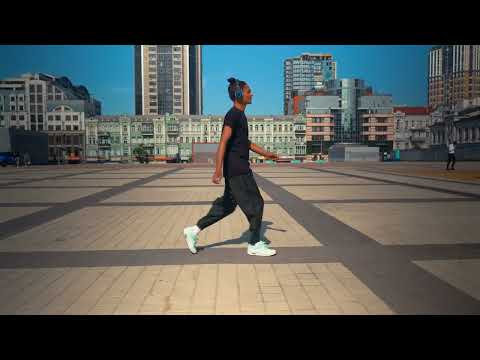

In [ ]:
from IPython.display import YouTubeVideo

YOUTUBE_ID = 'Mol0lrRBy3g'
YouTubeVideo(YOUTUBE_ID)

#Download Youtube Video

yt-dlp reference: https://www.reddit.com/r/youtubedl/wiki/howdoidownloadpartsofavideo/

To specify what part of the youtube video you want to use update the --download-sections argument using the following format including quotations:

"*[StartTime]-[EndTime]"

I would reccomend getting your start and end times from youtube first instead of guessing and checking.

In [ ]:
# ! sudo -H pip install --upgrade youtube-dl
! pip install yt-dlp

In [ ]:
!rm -rf video.mp4
# download the youtube with the given ID
!yt-dlp -f 'bestvideo[ext=mp4]' --download-sections "*0-5" --output "video.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID

[youtube] Extracting URL: https://www.youtube.com/watch?v=Mol0lrRBy3g
[youtube] Mol0lrRBy3g: Downloading webpage
[youtube] Mol0lrRBy3g: Downloading ios player API JSON
[youtube] Mol0lrRBy3g: Downloading tv player API JSON
[youtube] Mol0lrRBy3g: Downloading m3u8 information
[info] Mol0lrRBy3g: Downloading 1 format(s): 614
[info] Mol0lrRBy3g: Downloading 1 time ranges: 0.0-5.0
[download] Destination: video.mp4
[hls @ 0x5b8dc4076100] Skip ('#EXT-X-VERSION:6')
[hls @ 0x5b8dc4076100] Opening 'https://rr5---sn-q4fl6n6z.googlevideo.com/videoplayback/id/32897496b441cb78/itag/614/source/youtube/expire/1736877189/ei/JVCGZ62cJsrZsfIP85XfsAg/ip/34.125.225.168/requiressl/yes/ratebypass/yes/pfa/1/wft/1/sgovp/clen%3D3115135%3Bdur%3D11.878%3Bgir%3Dyes%3Bitag%3D248%3Blmt%3D1685604330551246/rqh/1/hls_chunk_host/rr5---sn-q4fl6n6z.googlevideo.com/xpc/EgVo2aDSNQ%3D%3D/met/1736855589,/mh/zj/mm/31,29/mn/sn-q4fl6n6z,sn-q4fzenee/ms/au,rdu/mv/m/mvi/5/pl/20/rms/au,au/pcm2/yes/initcwndbps/1622500/bui/AY2Et-MgHlps

#Executing Openpose Tracking and Writing Output Files
Notes:
1. Default number_people_max has been set to 1 to allow json -> matlab file conversion. You can change this but the code as written will not work for exporting matlab data for multiple subjects.

In [ ]:
#detect poses on this clip
!cd $OPENPOSE_PATH && rm ../openpose.avi
!cd $OPENPOSE_PATH && chmod -R 755 './build/'
!cd $OPENPOSE_PATH && ./build/examples/openpose/openpose.bin --video ../video.mp4 --write_json ../outputJson --display 0  --write_video ../openpose.avi --number_people_max 1

# convert the result into MP4
!ffmpeg -y -loglevel info -i openpose.avi output.mp4

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 19.037170 seconds.
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbi

#Seeing The Result!

Assuming all went well we should now be able to see our output video which includes the skeleton framing ontop of the primary subject.

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)

#Converting JSON Files Into Matlab Poses
Note:
1. Only works for single subject trainings at this time.

In [ ]:
from textwrap import indent
import scipy.io
from tqdm import tqdm
from typing import List, Dict, Any
import json

#Directory where your json files are being written to in colab
directory = '/content/outputJson'

OpenPoseMap = [
    "Nose",
    "Neck",
    "RShoulder",
    "RElbow",
    "RWrist",
    "LShoulder",
    "LElbow",
    "LWrist",
    "MidHip",
    "RHip",
    "RKnee",
    "RAnkle",
    "LHip",
    "LKnee",
    "LAnkle",
    "REye",
    "LEye",
    "REar",
    "LEar",
    "LBigToe",
    "LSmallToe",
    "LHeel",
    "RBigToe",
    "RSmallToe",
    "RHeel",
    "Background",
]


def batch(iterable, n=1):
    length = len(iterable)
    for index in range(0, length, n):
        yield iterable[index : min(index + n, length)]


def read_openpose_json(filename: str) -> List[Dict[str, Any]]:
    with open(filename, "rb") as f:
        keypoints_list = []
        keypoints = json.load(f)
        assert (
            len(keypoints["people"]) == 1
        ), "In all pictures, we should have only one person!"

        points_2d = keypoints["people"][0]["pose_keypoints_2d"]
        assert (
            len(points_2d) == 25 * 3
        ), "We have 25 points with (x, y, c); where c is confidence."

        for point_index, (x, y, confidence) in enumerate(batch(points_2d, 3)):
            assert x is not None, "x should be defined"
            assert y is not None, "y should be defined"
            assert confidence is not None, "confidence should be defined"
            keypoints_list.append(
                {
                    "x": x,
                    "y": y,
                    "c": confidence,
                    "point_label": OpenPoseMap[point_index],
                    "point_index": point_index,
                }
            )

        return keypoints_list


def get_all_openpose_json_files() -> List[str]:
    finalOutput = []
    ind = 0
    for filename in os.listdir(directory):
      f = os.path.join(directory, filename)
      finalOutput.insert(ind, f)
      ind += 1
    return finalOutput


poses = []
for filename in tqdm(get_all_openpose_json_files()):
    keypoints = read_openpose_json(filename)
    poses.append({"openpose_keypoints": keypoints})

# Save all at once
scipy.io.savemat("openpose_map.mat", {"OpenPoseMap": OpenPoseMap})
scipy.io.savemat("poses.mat", {"poses": poses})

100%|██████████| 150/150 [00:00<00:00, 16512.57it/s]


In [ ]:
!ls

cmake-3.17.2-Linux-x86_64.tar.gz  openpose	    output.json  poses.mat    youtube.mp4
drive				  openpose.avi	    outputJson	 sample_data
models.zip			  openpose_map.mat  output.mp4	 video.mp4


#Saving Your Data To Google Drive

**WARNING: EVERY EXECUTION OF THE FOLLOWING CELLS WILL OVERWRITE YOUR PREVIOUSLY WRITTEN GOOLGE DRIVE DATA WITH THE SAME NAME. MAKE SURE TO RENAME THE FILES IN DRIVE BEFORE RE-RUNNING THIS COMMAND IF YOU WISH TO SAVE YOUR PREVIOUS RESULTS**


In [ ]:
!cp /content/output.mp4 '/content/drive/My Drive/dataOutput'
!cp /content/openpose_map.mat '/content/drive/My Drive/dataOutput'
!cp /content/poses.mat '/content/drive/My Drive/dataOutput'

#Solid reference for some other arguments you can pass to the analysis tool.

In [ ]:
# Set the path to the absolute folder containing the images
# path = '/content/drive/MyDrive/dataset_neuman/dataset/lab/images'
# path = '/content/drive/MyDrive/dataset_Igualada/5/images'
#base_path = '/content/drive/MyDrive/SynWildDataset'
#path = '/content/drive/MyDrive/SynWildDataset/00000_random/image'
#IMAGE_FOLDER=path
#! IMAGE_FOLDER=path

#! cd $OPENPOSE_PATH && ./build/examples/openpose/openpose.bin \
#  --image_dir $IMAGE_FOLDER \
#  --display 0 \
#  --write_json $IMAGE_FOLDER/../openpose_json/ \
#  --write_images $IMAGE_FOLDER/../openpose_output/ \
#  --write_images_format jpg \
#  --render_pose 1 \
#  --render_threshold 0.5 \
#  --number_people_max 1 \
#  --model_pose BODY_25 \
#  --write_video $IMAGE_FOLDER/../openpose.avi \
#  --write_video_fps 3

#!ffmpeg -y -loglevel info -i $IMAGE_FOLDER/../openpose.avi $IMAGE_FOLDER/../output.mp4

#! python $base_path/scripts/custom/convert_openpose_json_to_npy.py \
#  --json_dir $IMAGE_FOLDER/../openpose_json/